In [1]:
import tensorflow as tf
import numpy as np
import os
from collections import defaultdict
import cv2
import matplotlib.pyplot as plt

/usr/local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
target_width = 5
target_height = 5
image_width = 80
image_height = 80
step_sizes = [2]

In [3]:
files = os.listdir('horizontal_trajectories/')
path = 'horizontal_trajectories/'
trajectories = defaultdict(list)

for f in files:
    if not f.endswith('.png'):
        continue
    trajectories[int(f.split('_')[0])].append(path+f)
    
for t in trajectories:
    trajectories[t].sort(key = lambda x: int(x.split('_')[2].split('.')[0]))

In [4]:
f = open(path + 'annotations.csv')
contents = f.read()
f.close()

contents = contents.split('\n')
headers = contents[0].split(',')
annotations = {}

for i in xrange(1, len(contents) - 1):
    current = contents[i].split(',')
    annotations[int(current[0])] = {}
    for j in xrange(1, 5):
        annotations[int(current[0])][headers[j]] = int(current[j])

In [5]:
X = tf.placeholder(dtype=tf.float32, shape=(1, 80, 80, 1), name='X')
prev_bbox = tf.placeholder(dtype=tf.float32, name='prev_bbox', shape=(1, 2))
final_bbox = tf.Variable(np.zeros((1, 2), np.float32), dtype=tf.float32)
current_bbox = tf.Variable(np.zeros((1, 2), np.float32), dtype=tf.float32)
upper_bound = tf.constant(np.array([[image_width, image_height]], np.float32))
y = tf.Variable(np.zeros((1, 3), np.float32), dtype=tf.float32)
action = tf.placeholder(dtype=tf.float32, shape=(1, 3), name='action')
current_trajectory_annotations = tf.placeholder(dtype=tf.float32, name='current_trajectory_annotations', shape=(1, 2))
overall_loss = tf.placeholder(dtype=tf.float32, name='overall_loss', shape=())

In [6]:
conv1 = tf.layers.conv2d(inputs=X, filters=32, kernel_size=[5, 5], activation=tf.nn.relu)
pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)
conv2 = tf.layers.conv2d(inputs=pool1, filters=16, kernel_size=[5, 5], activation=tf.nn.relu)
pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)
flat = tf.reshape(pool2, [-1, 17*17*16])
dense = tf.layers.dense(inputs=flat, units=1024, activation=tf.nn.relu)
dropout = tf.layers.dropout(inputs=dense, rate=0.4)
final = tf.nn.softmax(tf.layers.dense(inputs=tf.concat([(dropout), prev_bbox], 1), units=3))

In [7]:
optimizer_final = tf.train.GradientDescentOptimizer(learning_rate=0.001)
optimizer_individual = tf.train.GradientDescentOptimizer(learning_rate=0.001)

final_loss = tf.losses.absolute_difference(final_bbox, current_trajectory_annotations)
loss_individual = tf.reduce_sum(tf.losses.absolute_difference(action, y))

train_final = optimizer_final.minimize(loss=final_loss)
train_individual = optimizer_individual.minimize(loss=loss_individual)

1


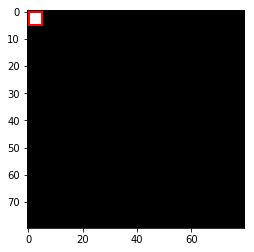

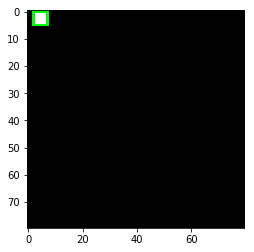

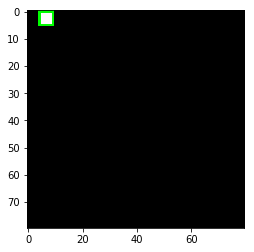

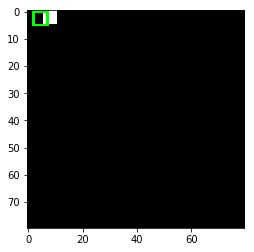

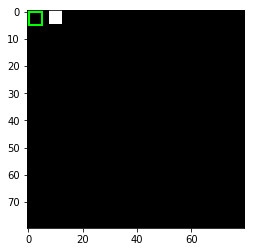

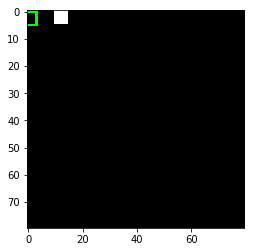

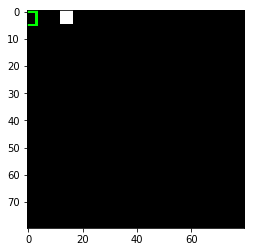

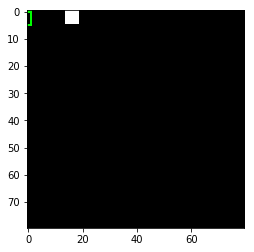

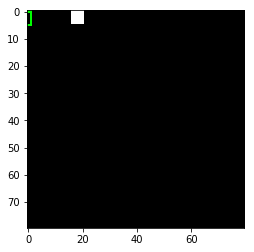

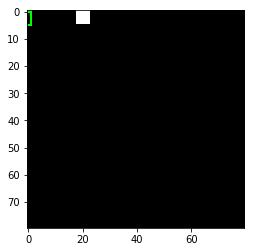

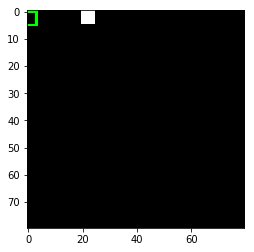

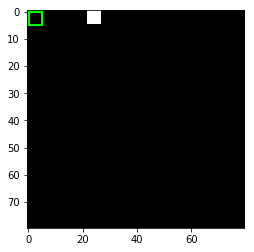

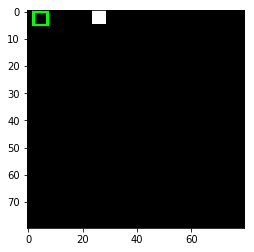

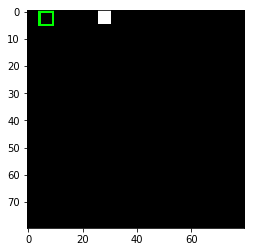

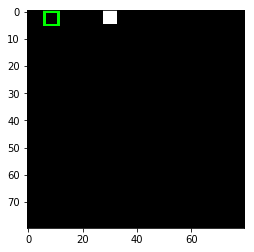

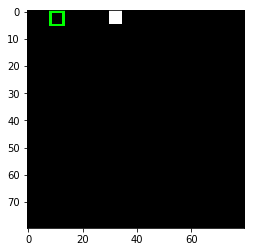

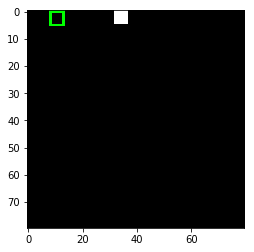

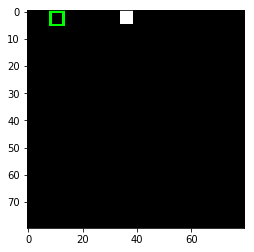

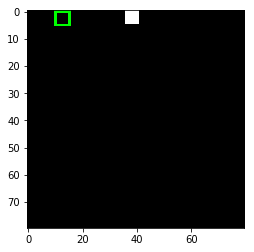

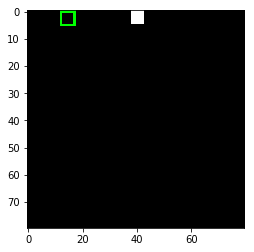

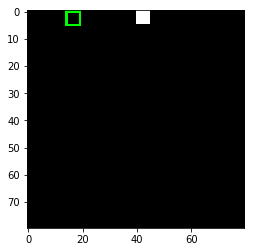

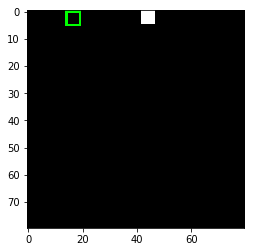

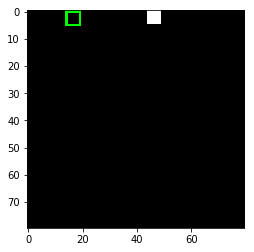

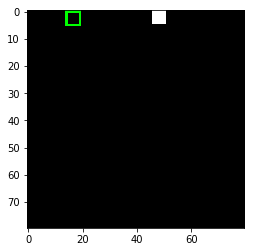

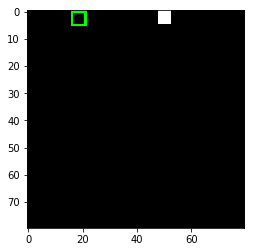

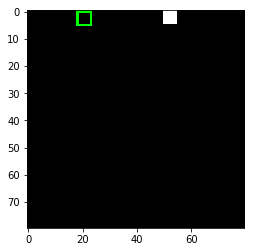

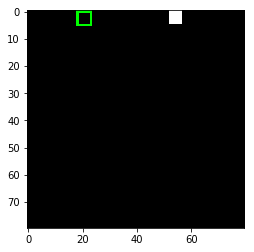

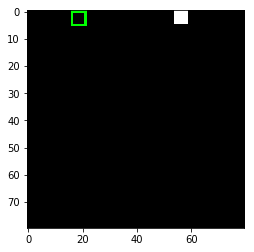

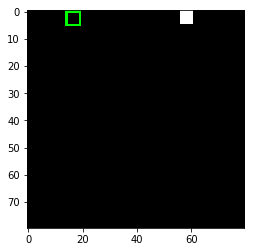

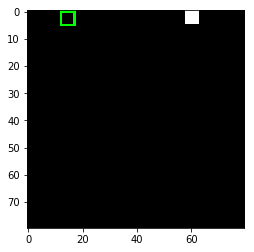

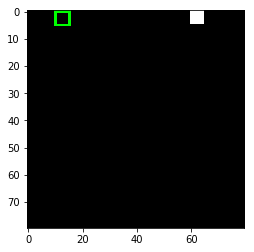

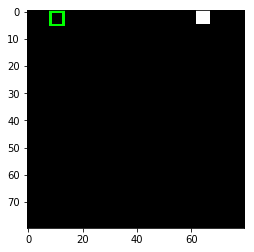

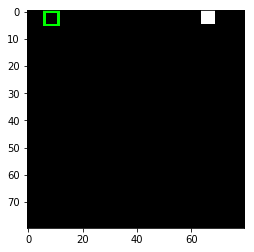

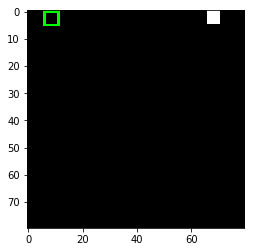

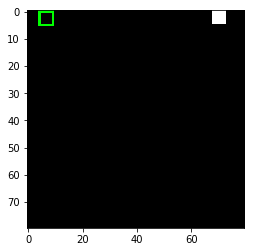

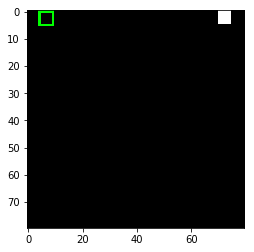

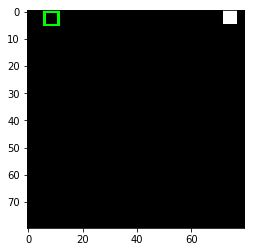

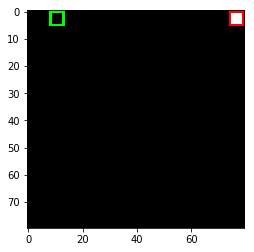

16.5


KeyboardInterrupt: 

In [11]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    count = 1
    while True:
        for t in trajectories:
            action_stack = []
            y_stack = []
            loss_values = []
            print count
            prev = np.array([[annotations[t]['start_x'], annotations[t]['start_y']]])
            img = cv2.imread(trajectories[t][0])
            cv2.rectangle(img,(prev[0][0], prev[0][1]),(prev[0][0]+target_width, prev[0][1]+target_height),(255,0,0),1)
            #cv2.imwrite('output_trajectories/' + str(count) + '_1.png', img)
            plt.imshow(img)
            plt.show()
            for i in xrange(1, len(trajectories[t])):
                img = cv2.imread(trajectories[t][i], cv2.IMREAD_GRAYSCALE)
                thresh, img = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
                img = np.array([img])
                img = tf.expand_dims(img, axis=3).eval()

                output = sess.run(final, feed_dict={X: img, prev_bbox: prev})
                sess.run(y.assign(output))
                left_prob = output[0][0]
                none_prob = output[0][1]
                right_prob = output[0][2]

                x = annotations[t]
                direction = np.random.uniform()

                left = 1 if direction <= left_prob else 0
                none = 1 if direction <= left_prob + none_prob and direction > left_prob else 0
                right = 1 if direction > left_prob + none_prob else 0

                random_step_size = step_sizes[np.random.randint(0, len(step_sizes))]
                current = np.array([[prev[0][0] + (-left + right)*random_step_size, prev[0][1]]])

                action_r = [left, none, right]

                action_stack.append(np.array([action_r]))
                y_stack.append(np.array(output))

                img = cv2.imread(trajectories[t][i])
                cv2.rectangle(img,(current[0][0], current[0][1]),(current[0][0]+target_width, current[0][1]+target_height),(0,255,0),1)
                if i == len(trajectories[t]) - 1:
                    cv2.rectangle(img,(annotations[t]['end_x'], annotations[t]['end_y']),(annotations[t]['end_x']+target_width, annotations[t]['end_y']+target_height),(255,0,0),1)

                #cv2.imwrite('output_trajectories/' + str(count) + '_' + str(i + 1) + '.png', img)

                plt.imshow(img)
                plt.show()

                if i == len(trajectories[t]) - 1:

                    sess.run(final_bbox.assign(tf.convert_to_tensor(current, dtype=tf.float32)))
                    overall_loss = sess.run([final_loss], feed_dict={current_trajectory_annotations: np.array([[annotations[t]['end_x'], annotations[t]['end_y']]])})[0]

                    overall_loss /= step_sizes[0]

                    print overall_loss

                    if overall_loss == 0.0:
                        break

                    for j in xrange(len(y_stack)-1, -1, -1):
                        #print j
                        sess.run(y.assign(y_stack[j] * overall_loss))
                        a = action_stack[j] * overall_loss
                        #print a
                        sess.run([train_individual], feed_dict={action: a})

                prev = current

            if overall_loss == 0.0:
                break

            count += 1
        
        if overall_loss == 0.0:
            break
    saver = tf.train.Saver()
    saver.save(sess, 'rl_model')